In [ ]:
pip install twstock

In [1]:
stockMap={
  "台積電":2330,
  "聯電": 2303,
  "聯發科": 2454,
  "矽統": 2363,
  "京元電子": 2449,
  "群創": 3481,
  "友達": 2409,
  "國碩": 2406,
  "中環": 2323,
  "佳能": 2374
}

In [2]:
import os
import numpy as np
import pandas as pd
import twstock
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#獲取topic的特徵
def read_files_to_list(folder_path):
    big_list = []
    filenames = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
    filenames.sort(key=lambda x: int(x.split('_')[0]))
    for filename in filenames:
        file_path = os.path.join(folder_path, filename)
        with open(file_path, 'r') as file:
            small_list = [line.strip() for line in file]
            big_list.append(small_list)
    return big_list[::-1]

#獲取新聞的特徵
def getNewsFeature(pathLDA, pathbert):
  feature1=np.array(read_files_to_list(pathLDA))
  df_csv = pd.read_csv(pathbert,index_col=0)
  feature2 = df_csv.to_numpy()
  feature = np.hstack((feature1, feature2))
  return feature.astype("float64")


def generate_dates_list():
    today = datetime.today()
    end_date = today - timedelta(days=365*5)
    delta = timedelta(days=1)

    dates_list = []
    current_date = today
    while current_date >= end_date:
        dates_list.append(current_date.strftime("%Y-%m-%d"))
        current_date -= delta
    r=dates_list.index("2024-05-28")
    a=dates_list.index("2022-01-01")
    dateList=dates_list[r:a+1]
    return dateList[::-1]

#獲取股票的歷史資料
def getHistoryData(stockCode):
    stockCode=f"{stockCode}"
    Dict={}
    stock=twstock.Stock(stockCode)
    HistoryData=stock.fetch_from(2022,4) #從2022年1月開始抓
    Dict["date"]=[]
    Dict["oepn"]=[]
    Dict["high"]=[]
    Dict["low"]=[]
    Dict["close"]=[]
    for data in HistoryData:
        Dict["date"].append(data.date.strftime("%Y-%m-%d"))
        Dict["oepn"].append(data.open)
        Dict["high"].append(data.high)
        Dict["low"].append(data.low)
        Dict["close"].append(data.close)
        if data.date.strftime("%Y-%m-%d")=="2024-05-28":
            break
    return Dict

def twoWeeksBefore(date_str):
    date = datetime.strptime(date_str, "%Y-%m-%d")
    two_weeks_ago = date - timedelta(weeks=2)
    return two_weeks_ago.strftime("%Y-%m-%d")

def getAllFeature(stockId, pathLdA, pathBert):
    Dict=getHistoryData(stockId)
    newsFeature=getNewsFeature(pathLdA, pathBert)
    date_index=generate_dates_list()
    Y_data=[]
    Y_dataDate=[]
    X_data=[]
    feature=[]
    for i in range(len(Dict["close"])-1):
        try:
            date1=Dict["date"][i]
            date2=twoWeeksBefore(date1)
            startDate=date_index.index(date2)
            endDate=date_index.index(date1)+1
            Y_data.append(Dict["close"][i+1]-Dict["close"][i])
            Y_dataDate.append(Dict["date"][i])
            X_data.append(newsFeature[startDate:endDate])
        except:
            continue
    split_index = int(len(X_data) * 0.8)
    X_train, X_test = X_data[:split_index], X_data[split_index:]
    Y_train, Y_test = Y_data[:split_index], Y_data[split_index:]
    return np.array(X_train).astype("float64"), np.array(Y_train), np.array(X_test).astype("float64"), np.array(Y_test)




In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(454, 15, 12)
(454,)
(114, 15, 12)
(114,)


In [3]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

class NewsLSTM():
  def __init__(self, featureNum):
    self.model=None
    self.n_steps=15
    self.predict_days=2
    self.features=featureNum
    self.scalerY=None

  def buildModel(self):
    self.model=Sequential()
    self.model.add(LSTM(64, return_sequences=True, input_shape = (self.n_steps, self.features)))
    self.model.add(LSTM(64))
    self.model.add(Dense(1))
    self.model.compile(loss='mse', optimizer='adam')
    return

  def train(self, X_train, Y_train, X_test, Y_test):
    self.buildModel()
    scaled_Y_train=self.Normalize(Y_train)
    self.model.fit(X_train, scaled_Y_train, batch_size=20, epochs=50)

    predictions=self.model.predict(X_test)
    predictions=self.scalerY.inverse_transform(predictions)
    predictions=predictions.flatten()
    self.computeError(predictions, Y_test)
    predictions=predictions*6
    return predictions

  def Normalize(self, Y_train):
    self.scalerY=MinMaxScaler(feature_range=(0,1))
    Y_train=Y_train.reshape(-1,1)
    scaled_Y_train = self.scalerY.fit_transform(Y_train)
    scaled_Y_train=scaled_Y_train.flatten()
    return scaled_Y_train

  def computeError(self, predictions, Y_test):
    mse = np.mean((predictions - Y_test) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(predictions - Y_test))
    return mse, rmse, mae

  def visualize(self, predictions, Y_test):
    plt.figure(figsize=(10, 6))
    plt.plot(Y_test, label='True Values', marker='o')
    plt.plot(predictions, label='Predicted Values', marker='x')
    plt.title('True Values vs Predicted Values')

    plt.ylabel('Value')
    plt.legend()
    plt.show()
    return


Epoch 1/50
21/21 [==============================] - 4s 20ms/step - loss: 0.0416
Epoch 2/50
21/21 [==============================] - 0s 17ms/step - loss: 0.0146
Epoch 3/50
21/21 [==============================] - 0s 18ms/step - loss: 0.0136
Epoch 4/50
21/21 [==============================] - 0s 18ms/step - loss: 0.0137
Epoch 5/50
21/21 [==============================] - 0s 18ms/step - loss: 0.0133
Epoch 6/50
21/21 [==============================] - 0s 18ms/step - loss: 0.0133
Epoch 7/50
21/21 [==============================] - 0s 17ms/step - loss: 0.0131
Epoch 8/50
21/21 [==============================] - 0s 18ms/step - loss: 0.0136
Epoch 9/50
21/21 [==============================] - 0s 18ms/step - loss: 0.0134
Epoch 10/50
21/21 [==============================] - 0s 18ms/step - loss: 0.0133
Epoch 11/50
21/21 [==============================] - 0s 19ms/step - loss: 0.0135
Epoch 12/50
21/21 [==============================] - 0s 18ms/step - loss: 0.0136
Epoch 13/50
21/21 [==================

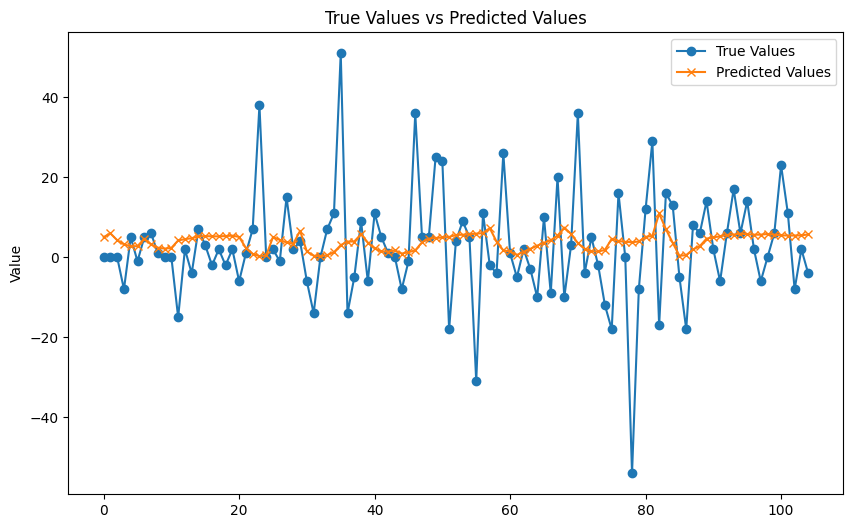

In [ ]:
stockID=stockMap["台積電"]
pathLDA=f"/content/drive/MyDrive/{stockID}"
pathBert=f"/content/drive/MyDrive/{stockID}.csv"
X_train, Y_train, X_test, Y_test=getAllFeature(stockID, pathLDA, pathBert)
lstm=NewsLSTM(12)
predictions=lstm.train(X_train, Y_train, X_test, Y_test)
mse, rmse, mae=lstm.computeError(predictions, Y_test)
print(f" mse: {mse}\n rmse: {rmse}\n mae: {mae}")
lstm.visualize(predictions, Y_test)

Epoch 1/50
21/21 [==============================] - 15s 33ms/step - loss: 0.0495
Epoch 2/50
21/21 [==============================] - 1s 31ms/step - loss: 0.0105
Epoch 3/50
21/21 [==============================] - 1s 30ms/step - loss: 0.0095
Epoch 4/50
21/21 [==============================] - 1s 32ms/step - loss: 0.0094
Epoch 5/50
21/21 [==============================] - 1s 43ms/step - loss: 0.0094
Epoch 6/50
21/21 [==============================] - 1s 23ms/step - loss: 0.0093
Epoch 7/50
21/21 [==============================] - 1s 31ms/step - loss: 0.0094
Epoch 8/50
21/21 [==============================] - 1s 29ms/step - loss: 0.0094
Epoch 9/50
21/21 [==============================] - 1s 30ms/step - loss: 0.0094
Epoch 10/50
21/21 [==============================] - 1s 34ms/step - loss: 0.0095
Epoch 11/50
21/21 [==============================] - 1s 37ms/step - loss: 0.0095
Epoch 12/50
21/21 [==============================] - 1s 27ms/step - loss: 0.0097
Epoch 13/50
21/21 [=================

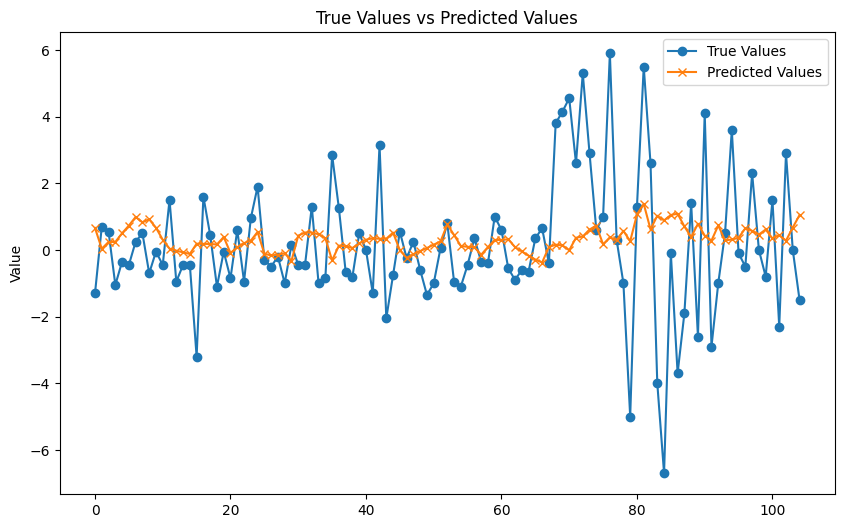

In [ ]:
#combine feature 台積電跟京元電子去預測矽統
stockID=stockMap["台積電"]
pathLDA=f"/content/drive/MyDrive/{stockID}"
pathBert=f"/content/drive/MyDrive/{stockID}.csv"
X1_train, Y1_train, X1_test, Y1_test=getAllFeature(stockID, pathLDA, pathBert)
stockID=stockMap["矽統"]
pathLDA=f"/content/drive/MyDrive/{stockID}"
pathBert=f"/content/drive/MyDrive/{stockID}.csv"
X2_train, Y2_train, X2_test, Y2_test=getAllFeature(stockID, pathLDA, pathBert)

X_train=(X1_train+X2_train)/2
Y_train=Y2_train

X_test=(X1_test+X2_test)/2
Y_test=Y2_test

lstm=NewsLSTM(12)
predictions=lstm.train(X_train, Y_train, X_test, Y_test)
mse, rmse, mae=lstm.computeError(predictions, Y_test)
print(f" mse: {mse}\n rmse: {rmse}\n mae: {mae}")
lstm.visualize(predictions, Y_test)

In [4]:
import twstock
import pandas as pd
from datetime import datetime, timedelta

def fetch_stock_data(stock_code, start_date, end_date):
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date= datetime.strptime(end_date, '%Y-%m-%d')
    stock = twstock.Stock(stock_code)
    data = stock.fetch_from(start_date.year, start_date.month)
    df = pd.DataFrame(data, columns=['date', 'capacity', 'turnover', 'open', 'high', 'low', 'close', 'change', 'transaction'])
    df.set_index('date', inplace=True)

    # 创建完整日期范围
    date_range = pd.date_range(start=start_date, end=end_date)

    df = df.reindex(date_range)
    df['close'].fillna(method='ffill', inplace=True)
    df['close'].fillna(method='bfill', inplace=True)
    df['high'].fillna(method='ffill', inplace=True)
    df['high'].fillna(method='bfill', inplace=True)
    df['low'].fillna(method='ffill', inplace=True)
    df['low'].fillna(method='bfill', inplace=True)
    df['change'].fillna(method='ffill', inplace=True)
    df['change'].fillna(method='bfill', inplace=True)
    df['open'].fillna(method='ffill', inplace=True)
    df['open'].fillna(method='bfill', inplace=True)
    stock=[]
    # 转换为列表
    stock.append(df['open'].tolist())
    stock.append(df['high'].tolist())
    stock.append(df['low'].tolist())
    stock.append(df['close'].tolist())
    stock.append(df['change'].tolist())
    return np.array(stock).T

In [5]:
#加入新聞外的特徵，開盤價....
from tqdm import trange
def getAllFeature(stockId, pathLdA, pathBert):
  Dict=getHistoryData(stockId)
  newsFeature=getNewsFeature(pathLdA, pathBert)
  date_index=generate_dates_list()
  Y_data=[]
  Y_dataDate=[]
  X_data=[]
  feature=[]
  for i in trange(len(Dict["close"])-1):
    try:
      date1=Dict["date"][i]
      date2=twoWeeksBefore(date1)
      startDate=date_index.index(date2)
      endDate=date_index.index(date1)+1
      Y_data.append(Dict["close"][i+1]-Dict["close"][i])
      Y_dataDate.append(Dict["date"][i])
      newfeature=np.array(newsFeature[startDate:endDate]).astype("float64")
      stockfeature=fetch_stock_data(f"{stockId}", date2, date1).astype("float64")
      feature=np.hstack((newfeature, stockfeature))
      print(feature.shape)
      X_data.append(feature)
    except:
      print("not")
      continue
  split_index = int(len(X_data) * 0.8)
  X_train, X_test = X_data[:split_index], X_data[split_index:]
  Y_train, Y_test = Y_data[:split_index], Y_data[split_index:]
  return np.array(X_train).astype("float64"), np.array(Y_train), np.array(X_test).astype("float64"), np.array(Y_test)

In [ ]:
stockID=stockMap["台積電"]
pathLDA=f"/content/drive/MyDrive/{stockID}"
pathBert=f"/content/drive/MyDrive/{stockID}.csv"
X1_train, Y1_train, X1_test, Y1_test=getAllFeature(stockID, pathLDA, pathBert)

Epoch 1/50
21/21 [==============================] - 5s 28ms/step - loss: 0.0266
Epoch 2/50
21/21 [==============================] - 1s 29ms/step - loss: 0.0139
Epoch 3/50
21/21 [==============================] - 1s 27ms/step - loss: 0.0134
Epoch 4/50
21/21 [==============================] - 1s 26ms/step - loss: 0.0137
Epoch 5/50
21/21 [==============================] - 1s 27ms/step - loss: 0.0137
Epoch 6/50
21/21 [==============================] - 1s 27ms/step - loss: 0.0147
Epoch 7/50
21/21 [==============================] - 0s 18ms/step - loss: 0.0160
Epoch 8/50
21/21 [==============================] - 0s 18ms/step - loss: 0.0135
Epoch 9/50
21/21 [==============================] - 0s 17ms/step - loss: 0.0134
Epoch 10/50
21/21 [==============================] - 0s 17ms/step - loss: 0.0134
Epoch 11/50
21/21 [==============================] - 0s 17ms/step - loss: 0.0136
Epoch 12/50
21/21 [==============================] - 0s 18ms/step - loss: 0.0137
Epoch 13/50
21/21 [==================

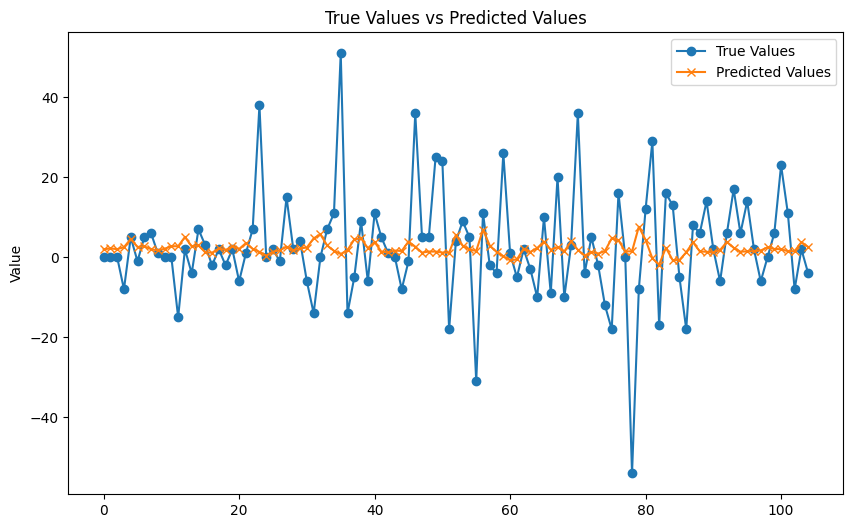

In [7]:
lstm=NewsLSTM(17)
predictions=lstm.train(X1_train, Y1_train, X1_test, Y1_test)
mse, rmse, mae=lstm.computeError(predictions, Y1_test)
print(f" mse: {mse}\n rmse: {rmse}\n mae: {mae}")
lstm.visualize(predictions, Y1_test)